# WCM Meeting Jun, 2022

## Imports, setup

In [1]:
import projectpath

import collections
import copy
from importlib import resources

import equilibrator_api
import escher
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from viv.experiment.glycolysis import SimpleModel
from viv.process.fba_process import FbaProcess
from vivarium.core.engine import Engine, pf

from mosmo.model import Molecule, Reaction, Pathway, ReactionNetwork
from mosmo.knowledge import kb
from mosmo.sim import fba_gd
from mosmo.sim.elementary_modes import elementary_modes
import mosmo.preso.escher.pw as pw_files

escher_options = {
    'width': 600,
    'height': 600,
    'map_json': resources.read_text(pw_files, 'glycolysis_ppp_ed.json'),
    'menu': 'zoom',
    'enable_editing': False,
    'never_ask_before_quit': True,
    'metabolite_styles': ['color', 'size'],
    'metabolite_scale': [
        {'type': 'value', 'value': 0.0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 3.0, 'color': '#771fb4', 'size': 30},
    ],
    'reaction_styles': ['color', 'size', 'abs'],
    'reaction_scale': [
        {'type': 'value', 'value': 0.0, 'color': '#eeeeee', 'size': 3},
        {'type': 'value', 'value': 3.0, 'color': '#1f77b4', 'size': 30},
    ],
}

KB = kb.configure_kb()

cc = equilibrator_api.ComponentContribution()
Q_ = equilibrator_api.Q_
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

def find_cc_met(met):
    if met.xrefs:
        for xref in met.xrefs:
            if xref.db == 'KEGG':
                return cc.get_compound(f'KEGG:{xref.id}')
    return None


## Define pathways, reactions, metabolites

In [2]:
# Pathways
glycolysis = KB.find(KB.pathways, 'glycolysis')[0]
ppp = KB.find(KB.pathways, 'pentose phosphate')[0]

# Reactions (some included in above pathways, some not)
pts = KB('pts.glc')

# Overall reaction network
network = ReactionNetwork(glycolysis.steps + ppp.steps + [pts])
print(f'The network has {network.shape[1]} reactions over {network.shape[0]} metabolites')


# Key metabolites, all involved in some reaction and/or pathway above
glc_ex = KB('Glc.D.ext')
g6p = KB('Glc.D.6P')
r5p = KB('Rib.D.5P')
e4p = KB('Ery.D.4P')
amp = KB('amp')
adp = KB('adp')
atp = KB('atp')
pi = KB('pi')
nad = KB('nad.ox')
nadh = KB('nad.red')
nadp = KB('nadp.ox')
nadph = KB('nadp.red')
pep = KB('pep')
pyr = KB('pyr')
coA = KB('coa')
acCoA = KB('accoa')
co2 = KB('co2')
proton = KB('h+')
water = KB('h2o')

# Concentrations of (potentially) external metabolites, in mM, taken from Rabinowitz 2016
concs = {
    glc_ex: 10.,  # Arbitrary, environment
    g6p: 7.88,
    r5p: 7.87e-01,
    e4p: 4.90e-02,
    amp: 2.81e-01,
    adp: 5.55e-01,
    atp: 9.63,
    pi: 23.9,
    nad: 2.55,
    nadh: 8.36e-02,
    nadp: 2.08e-03,
    nadph: 1.21e-01,
    pep: 1.84e-01,
    pyr: 3.66,
    coA: 1.37,
    acCoA: 6.06e-01,
    co2: 7.52e-02,
    proton: 1e-7,
    water: 55500.,
}

The network has 21 reactions over 31 metabolites


## Glycolsis+ process with a proportional controller, driven by acCoA

In [3]:
# Focus only on mainline glycolysis to acCoA for now.
bounds = [glc_ex, acCoA, adp, amp, atp, pi, nad, nadh, coA, co2, proton, water]

config = {
    'fba_process': {
        'reactions': network.reactions,
        'drivers': {
            acCoA: concs[acCoA],
        },
    },
    'clamp': {
        'targets': {
            met: concs[met] for met in bounds if met != acCoA
        }
    },
    'drain': {
        'rates': {
            acCoA: concs[acCoA] * 0.05,
        }
    },
}

composer = SimpleModel(config)
composite = composer.generate()
sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })
sim.update(30)


Simulation ID: 43f2d5b4-cd00-11ed-a497-8f0e93d9c9ed
Created: 03/27/2023 at 17:34:14
Completed in 0.710305 seconds


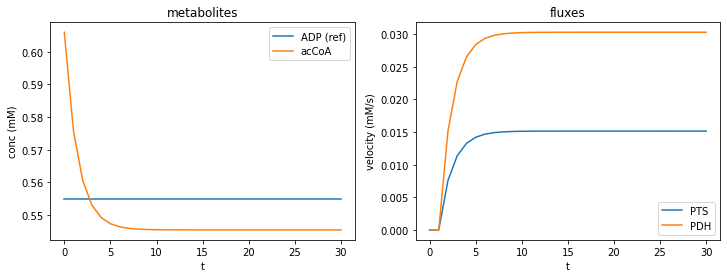

In [4]:
data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['adp'], label='ADP (ref)')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].set_title('metabolites')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('fluxes')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

### Upgrade to PID controller

In [5]:
config['fba_process']['pid_kp'] = 0.7
config['fba_process']['pid_ki'] = 0.1

composer = SimpleModel(config)
composite = composer.generate()
sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })
sim.update(30)


Simulation ID: 43f2d5b5-cd00-11ed-a497-8f0e93d9c9ed
Created: 03/27/2023 at 17:34:15
Completed in 0.425213 seconds


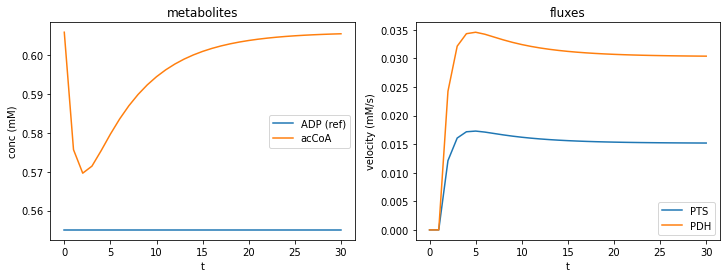

In [6]:
data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['adp'], label='ADP (ref)')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].set_title('metabolites')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('fluxes')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

### Shifting objectives

In [7]:
bounds = [glc_ex, e4p, r5p, acCoA, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]
drivers = [e4p, r5p, acCoA]

config = {
    'fba_process': {
        'reactions': network.reactions,
        'drivers': {met: concs[met] for met in drivers},
        'pid_kp': 0.7,
        'pid_ki': 0.1,
    },
    'clamp': {
        'targets': {
            met: concs[met] for met in bounds if met not in drivers
        }
    },
    'drain': {
        'rates': {met: 0.0 for met in drivers}  # Rates will be set dynamically
    },
}

composer = SimpleModel(config)
composite = composer.generate()
drain = composite.processes['drain']

sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })

drain.rates[e4p] = 0.
drain.rates[r5p] = 0.
drain.rates[acCoA] = 0.03
sim.update(30)

drain.rates[e4p] = 0.01
drain.rates[r5p] = 0.05
drain.rates[acCoA] = 0.02
sim.update(30)

drain.rates[e4p] = 0.03
drain.rates[r5p] = 0.01
drain.rates[acCoA] = 0.0
sim.update(30)


Simulation ID: 43f2d5b6-cd00-11ed-a497-8f0e93d9c9ed
Created: 03/27/2023 at 17:34:15
Completed in 0.509896 seconds
Completed in 0.297309 seconds
Completed in 0.149452 seconds


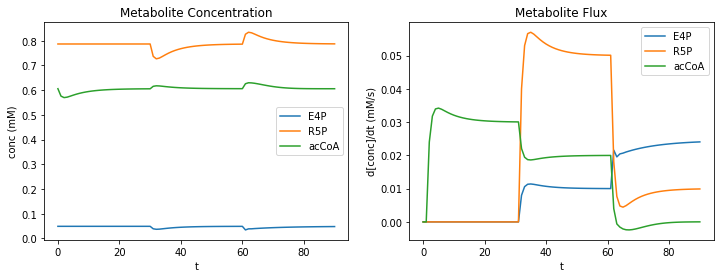

In [8]:
data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())
dmdt_t = pd.DataFrame((network.s_matrix @ flux_t.to_numpy().T).T, columns=(met.id for met in network.reactants))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['Ery.D.4P'], label='E4P')
ax[0].plot(conc_t.index, conc_t['Rib.D.5P'], label='R5P')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].set_title('Metabolite Concentration')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[1].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[1].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[1].set_title('Metabolite Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('d[conc]/dt (mM/s)')
ax[1].legend()

plt.show()


### But something is unconstrained, and erratic...

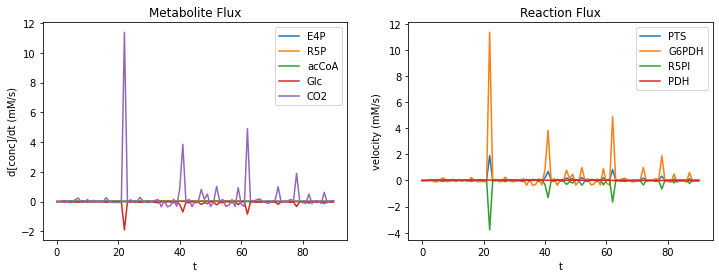

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[0].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[0].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[0].plot(dmdt_t.index, dmdt_t['Glc.D.ext'], label='Glc')
ax[0].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[0].set_title('Metabolite Flux')
ax[0].set_xlabel('t')
ax[0].set_ylabel('d[conc]/dt (mM/s)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['g6pdh'], label='G6PDH')
ax[1].plot(flux_t.index, flux_t['r5pi'], label='R5PI')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('Reaction Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

### Solution: also constrain CO2


Simulation ID: 45cbc292-cd00-11ed-a497-8f0e93d9c9ed
Created: 03/27/2023 at 17:34:17
Completed in 0.445305 seconds
Completed in 0.256114 seconds
Completed in 0.127796 seconds


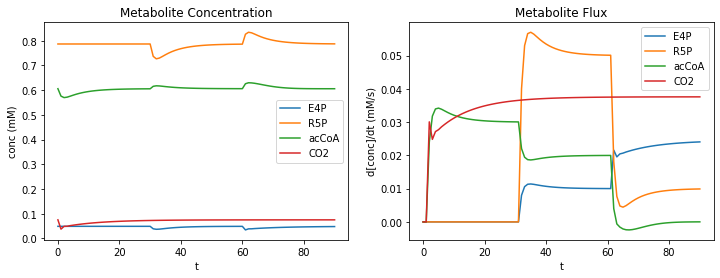

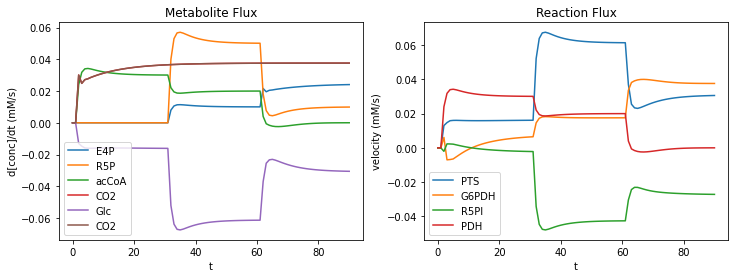

In [10]:
bounds = [glc_ex, e4p, r5p, acCoA, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]
drivers = [e4p, r5p, acCoA, co2]

config = {
    'fba_process': {
        'reactions': network.reactions,
        'drivers': {met: concs[met] for met in drivers},
        'pid_kp': 0.7,
        'pid_ki': 0.1,
    },
    'clamp': {
        'targets': {
            met: concs[met] for met in bounds if met not in drivers
        }
    },
    'drain': {
        'rates': {met: 0.0 for met in drivers}  # Rates will be set dynamically
    },
}

composer = SimpleModel(config)
composite = composer.generate()
drain = composite.processes['drain']

sim = Engine(
    composite=composite,
    initial_state={
        'metabolites': {
            met.id: concs[met] for met in bounds
        }
    })

drain.rates[e4p] = 0.
drain.rates[r5p] = 0.
drain.rates[acCoA] = 0.03
drain.rates[co2] = 0.04
sim.update(30)

drain.rates[e4p] = 0.01
drain.rates[r5p] = 0.05
drain.rates[acCoA] = 0.02
sim.update(30)

drain.rates[e4p] = 0.03
drain.rates[r5p] = 0.01
drain.rates[acCoA] = 0.0
sim.update(30)

data = sim.emitter.get_data()
conc_t = pd.DataFrame(step['metabolites'] for step in data.values())
flux_t = pd.DataFrame(step['fluxes'] for step in data.values())
dmdt_t = pd.DataFrame((network.s_matrix @ flux_t.to_numpy().T).T, columns=(met.id for met in network.reactants))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(conc_t.index, conc_t['Ery.D.4P'], label='E4P')
ax[0].plot(conc_t.index, conc_t['Rib.D.5P'], label='R5P')
ax[0].plot(conc_t.index, conc_t['accoa'], label='acCoA')
ax[0].plot(conc_t.index, conc_t['co2'], label='CO2')
ax[0].set_title('Metabolite Concentration')
ax[0].set_xlabel('t')
ax[0].set_ylabel('conc (mM)')
ax[0].legend()

ax[1].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[1].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[1].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[1].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[1].set_title('Metabolite Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('d[conc]/dt (mM/s)')
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(dmdt_t.index, dmdt_t['Ery.D.4P'], label='E4P')
ax[0].plot(dmdt_t.index, dmdt_t['Rib.D.5P'], label='R5P')
ax[0].plot(dmdt_t.index, dmdt_t['accoa'], label='acCoA')
ax[0].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[0].plot(dmdt_t.index, dmdt_t['Glc.D.ext'], label='Glc')
ax[0].plot(dmdt_t.index, dmdt_t['co2'], label='CO2')
ax[0].set_title('Metabolite Flux')
ax[0].set_xlabel('t')
ax[0].set_ylabel('d[conc]/dt (mM/s)')
ax[0].legend()

ax[1].plot(flux_t.index, flux_t['pts.glc'], label='PTS')
ax[1].plot(flux_t.index, flux_t['g6pdh'], label='G6PDH')
ax[1].plot(flux_t.index, flux_t['r5pi'], label='R5PI')
ax[1].plot(flux_t.index, flux_t['pdh'], label='PDH')
ax[1].set_title('Reaction Flux')
ax[1].set_xlabel('t')
ax[1].set_ylabel('velocity (mM/s)')
ax[1].legend()

plt.show()

## Thermodynamic Controller

### State-dependent $\Delta{G} = \Delta{G^{\circ}} + R T ln{Q}$ for all reactions

In [11]:
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

# More complete list of concentrattions. All taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4912430/, except where noted.
concs = {KB(met_id): conc for met_id, conc in [
    ('2pg', 9.18e-02),
    ('3pg', 1.54),
    ('6pg', 3.77),
    ('6pgdl', 1.), # Not provided; wild guess
    ('Ery.D.4P', 4.90e-02),
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.ext', 10.),  # Arbitrary, environment
    ('Glc.D.6P', 7.88),
    ('Rib.D.5P', 7.87e-01),
    ('Rul.D.5P', 1.12e-01),
    ('Sed.D.7P', 8.82e-01),
    ('Xul.D.5P', 1.81e-01),
    ('accoa', 6.06e-01),
    ('adp', 5.55e-01),
    ('amp', 2.81e-01),
    ('atp', 9.63),
    ('co2', 7.52e-02),
    ('coa', 1.37),
    ('dhap', 3.06),
    ('dpg', 1.65e-02),
    ('gap', 2.71e-01),
    ('h+', 1e-7),
    ('h2o', 55500),
    ('nad.ox', 2.55),
    ('nad.red', 8.36e-02),
    ('nadp.ox', 2.08e-03),
    ('nadp.red', 1.21e-01),
    ('pep', 1.84e-01),
    ('pi', 23.9),
    ('pyr', 3.66),
]}

def calculate_dg(reaction, concs):
    cc_stoich = {}
    rxn_q = 1.0
    for met, count in reaction.stoichiometry.items():
        cc_stoich[find_cc_met(met)] = count
        if met not in (proton, water):  # Excluded from K, and therefore Q (?)
            # Concentrations are in mM, but ΔG is standardized on M
            rxn_q = rxn_q * (concs[met] * 1e-3)**count

    cc_rxn = equilibrator_api.Reaction(cc_stoich)
    dg0 = cc.standard_dg_prime(cc_rxn)
    dg = dg0 + cc.RT * np.log(rxn_q)
    return dg0, dg

dg0s = {}
dgs = {}
for reaction in network.reactions:
    dg0, dg = calculate_dg(reaction, concs)
    # TODO: figure out pint (units) and uncertainties. For now, jump straight to the value
    dg0s[reaction] = dg0.n
    dgs[reaction] = dg.n

print(f'Calculated ΔG° and ΔG for {len(dgs)} reactions')

Calculated ΔG° and ΔG for 21 reactions


### Specific path from G6P to pyruvate

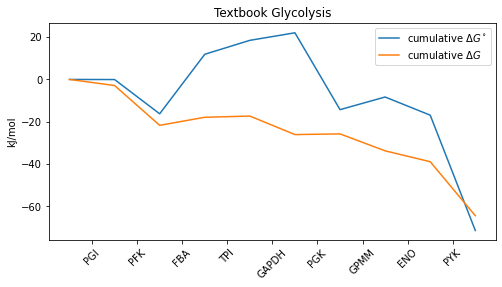

In [12]:
path = [
    (KB('pgi'), 1),
    (KB('pfk'), 1),
    (KB('fba'), 1),
    (KB('tpi'), -1),
    (KB('gapdh'), 2),
    (KB('pgk'), -2),
    (KB('gpm.indep'), -2),
    (KB('eno'), 2),
    (KB('pyk'), -2),
]

path_dg0 = [0.]
path_dg = [0.]
for step, coeff in path:
    path_dg0.append(dg0s[step] * coeff)
    path_dg.append(dgs[step] * coeff)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.cumsum(path_dg0), label='cumulative $\Delta{G}^{\circ}$')
ax.plot(np.cumsum(path_dg), label='cumulative $\Delta{G}$')
ax.set_xticks(np.arange(len(path)) + 0.5, (rxn.label for rxn, coeff in path), rotation=45)
ax.set_title('Textbook Glycolysis')
ax.set_ylabel('kJ/mol')
ax.legend()
plt.show()

### Thermodynamics of the Net Reaction

In [13]:
class NetReaction:
    def __init__(self, reactions=None):
        self.reactions = collections.defaultdict(int)
        self._stoichiometry = collections.defaultdict(int)
        if reactions is not None:
            for reaction, multiplier in reactions:
                self.add_reaction(reaction, multiplier)
    
    def add_reaction(self, reaction, multiplier):
        for reactant, count in reaction.stoichiometry.items():
            self._stoichiometry[reactant] += count * multiplier
        self.reactions[reaction] += multiplier
    
    @property
    def stoichiometry(self):
        return {met: count for met, count in self._stoichiometry.items() if count != 0}

path_net = NetReaction(path)
print('Net reaction:')
print('\n'.join(f'{count:+4d} {met.shorthand}' for met, count in path_net.stoichiometry.items()))

net_dg0, net_dg = calculate_dg(path_net, concs)
print()
print(f'ΔG of net reaction: {net_dg:.2f}; Sum of ΔG of steps: {np.sum(path_dg):.2f}')

Net reaction:
  -1 G6P
  +3 ATP
  -3 ADP
  +1 H+
  -2 NAD+
  -2 Pi
  +2 NADH
  +2 H2O
  +2 pyr

ΔG of net reaction: (-64.37 +/- 1.54) kilojoule / mole; Sum of ΔG of steps: -64.37


## Elementary Modes

In [14]:
def build_internal_system(network, bounds):
    """Returns S matrix with rows for internal (non-bounds) metabolites only."""
    intermediates = [met not in bounds for met in network.reactants]
    return network.s_matrix[intermediates].astype(int)

def mode_formula(network, mode):
    parts = []
    for reaction, coeff in zip(network.reactions.labels(), mode):
        if coeff == -1:
            parts.append('-')
        elif coeff < 0:
            parts.append(f'- {-coeff}')
        elif coeff == 1:
            if parts:
                parts.append('+')
        elif coeff > 0:
            if parts:
                parts.append(f'+ {coeff}')
            else:
                parts.append(f'{coeff}')
        
        if coeff:
            parts.append(reaction)
    
    return ' '.join(parts)

def show_modes(network, modes, rev):
    s_elementary = (network.s_matrix.astype(int) @ modes)
    net_reactions = []
    for i, (mode, reversible) in enumerate(zip(s_elementary.T, rev)):
        stoich = {}
        for met, count in zip(network.reactants, mode):
            if count != 0:
                stoich[met] = count

        net_reaction = Reaction(_id=f'mode{i}', name=f'Elementary Mode {i}', stoichiometry=stoich, reversible=reversible)
        net_reactions.append(net_reaction)

    w = f'{160 + modes.shape[1] * 8:d}px' if modes.shape[1] < 80 else '100%'
    mode_select = widgets.IntSlider(
        value=0,
        min=0,
        max=modes.shape[1] - 1,
        description='Mode',
        continuous_update=True,
        readout=True,
        layout={'width': w}
    )
    mode_fluxes = widgets.Text(description='flux ratios', layout={'width': '100%'})
    mode_net = widgets.Text(description='net reaction', layout={'width': '100%'})
    diag = escher.Builder(**escher_options)

    def show_mode(change):
        mode = mode_select.value
        mode_fluxes.value = mode_formula(network, modes.T[mode])
        mode_net.value = (net_reactions[mode]).formula
        diag.reaction_data = {r: v for r, v in zip(network.reactions.labels(), modes.T[mode])}

    mode_select.observe(show_mode, names='value')
    show_mode(None)

    return widgets.VBox([mode_select, mode_fluxes, mode_net, diag])

In [15]:
# Results are cleaner for the network without PTS, and boundaries chosen for illustration purposes
network = ReactionNetwork(glycolysis.steps + ppp.steps)
# bounds = [g6p, e4p, r5p, acCoA, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]
bounds = [g6p, r5p, pyr, adp, amp, atp, pi, nad, nadh, nadp, nadph, coA, co2, proton, water]

%time modes, rev = elementary_modes(build_internal_system(network, bounds), (reaction.reversible for reaction in network.reactions))
show_modes(network, modes, rev)

CPU times: user 15.3 ms, sys: 60.9 ms, total: 76.2 ms
Wall time: 11 ms


### Mode - reaction matrix

In [16]:
pd.DataFrame(modes, index=network.reactions.labels())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
PGI,0,0,1,-1,-1,0,-2,0,0,-2,0,0,2,0,2,0,5,5,-5,-5
PFK,1,0,1,0,0,0,0,2,0,0,2,0,0,0,0,0,1,1,0,0
FBP,1,0,0,1,1,0,0,0,2,0,0,2,0,2,0,2,0,0,1,1
FBA,0,0,1,-1,-1,0,0,2,-2,0,2,-2,0,-2,0,-2,1,1,-1,-1
TPI,0,0,-1,1,1,0,0,-2,2,0,-2,2,0,2,0,2,-1,-1,1,1
GAPDH,0,0,2,-2,-2,0,1,5,-5,1,5,-5,-1,-5,-1,-5,0,0,0,0
PGK,0,0,-2,2,2,0,-1,-5,5,-1,-5,5,1,5,1,5,0,0,0,0
GPMM,0,0,-2,2,2,0,-1,-5,5,-1,-5,5,1,5,1,5,0,0,0,0
ENO,0,0,2,-2,-2,0,1,5,-5,1,5,-5,-1,-5,-1,-5,0,0,0,0
PYK,0,-1,-2,2,0,0,-1,-5,5,-1,-5,5,0,0,0,0,0,0,0,0


### Mode net reaction S-matrix

In [17]:
s = network.s_matrix @ modes
keep = np.any(s, axis=1)

pd.DataFrame(s[keep], index=np.array(network.reactants.labels())[keep], dtype=int)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
G6P,0,0,-1,1,1,-1,2,0,0,0,-2,2,-2,0,0,2,-5,-1,5,1
ATP,-1,0,3,-4,-4,0,2,8,-10,2,8,-10,-2,-10,-2,-10,-1,-1,0,0
ADP,1,-1,-3,4,2,0,-2,-8,10,-2,-8,10,1,5,1,5,1,1,0,0
H+,1,1,1,0,2,2,0,2,0,4,6,-4,1,5,-3,1,1,-7,0,8
H2O,-1,-1,2,-3,-5,-1,1,5,-7,-1,3,-5,-2,-12,0,-10,0,4,-1,-5
Pi,1,1,-2,3,5,0,-1,-5,7,-1,-5,7,2,12,2,12,0,0,1,1
NAD+,0,0,-2,2,2,0,-1,-5,5,-1,-5,5,1,5,1,5,0,0,0,0
NADH,0,0,2,-2,-2,0,1,5,-5,1,5,-5,-1,-5,-1,-5,0,0,0,0
pyr,0,0,2,-2,-2,0,1,5,-5,1,5,-5,-1,-5,-1,-5,0,0,0,0
AMP,0,1,0,0,2,0,0,0,0,0,0,0,1,5,1,5,0,0,0,0


In [18]:
net_reactions = []
for j, (col, reversible) in enumerate(zip((network.s_matrix @ modes).T, rev)):
    stoich = {}
    for i, count in enumerate(col):
        if count != 0:
            stoich[network.reactants[i]] = count
    
    net_reactions.append(Reaction(
        _id=f'mode_{j}',
        name=f'Mode {j} net reaction',
        stoichiometry=stoich,
        reversible=reversible,
    ))

In [19]:
dg_data = []
for i, (net_reaction, reversible) in enumerate(zip(net_reactions, rev)):
    dg0, dg = calculate_dg(net_reaction, concs)
    dg_data.append({'ΔG°': dg0.n, 'ΔG': dg.n, 'rev': reversible})

mode_dg = pd.DataFrame(dg_data)
mode_dg

,ΔG°,ΔG,rev
0,-30.128631,-46.450112,False
1,-28.055906,-38.993364,False
2,-71.348222,-64.371232,False
3,41.219592,17.921119,False
4,-14.892220,-60.065608,False
5,-24.253139,-33.351898,True
6,-66.566356,-36.418318,True
7,-209.262800,-165.160781,False
8,149.005539,72.260557,False
9,-115.072635,-103.122114,True


- Regulation filter: eliminate modes using FBP or PPS (under these conditions)
- Thermodynamic filter: eliminate irreversible modes with ΔG > 0

In [20]:
excluded_reactions = [j for j, rxn in enumerate(network.reactions) if rxn.id in ('fbp', 'pps')]
active_modes = []
active_mode_idx = []
for i, (mode, net_reaction) in enumerate(zip(modes.T, net_reactions)):
    if np.sum(np.abs(mode[excluded_reactions])) == 0 and (mode_dg['ΔG'][i] < 0 or mode_dg['rev'][i]):
        active_modes.append(net_reaction)
        active_mode_idx.append(i)
print(f'Active modes: {len(active_modes)} out of {len(net_reactions)}')

Active modes: 6 out of 20


In [21]:
show_modes(network, modes.T[active_mode_idx].T, np.array(rev)[active_mode_idx])